In [2]:
import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

In [3]:
# Change to your settings...
############################
N_vocab = 130
encode_appearance = True
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.03 # doesn't have effect in testing
ckpt_path = '/local/home/mikarimov/codebase/mycode/nerf_pl/ckpts/eth-hg-1ps-fast-dense/epoch=14.ckpt'

N_emb_xyz = 10
N_emb_dir = 4
N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(N_emb_xyz-1, N_emb_xyz)
embedding_dir = PosEmbedding(N_emb_dir-1, N_emb_dir)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(N_vocab, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(N_vocab, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse',
                   in_channels_xyz=6*N_emb_xyz+3,
                   in_channels_dir=6*N_emb_dir+3).cuda()
nerf_fine = NeRF('fine',
                 in_channels_xyz=6*N_emb_xyz+3,
                 in_channels_dir=6*N_emb_dir+3,
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [4]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        if 'a_embedded' in kwargs:
            kwargs_['a_embedded'] = kwargs['a_embedded'][i:i+chunk]
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on the image of Fig 4 in the paper

In [8]:
dataset = dataset_dict['phototourism'] \
          ('/local/home/mikarimov/codebase/data/eth-hg-1ps-fast-dense',
           split='test_train',
           img_downscale=2, use_cache=False)
print(dataset)

In [9]:
sample = dataset[59]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

AttributeError: 'PhototourismDataset' object has no attribute 'poses_test'

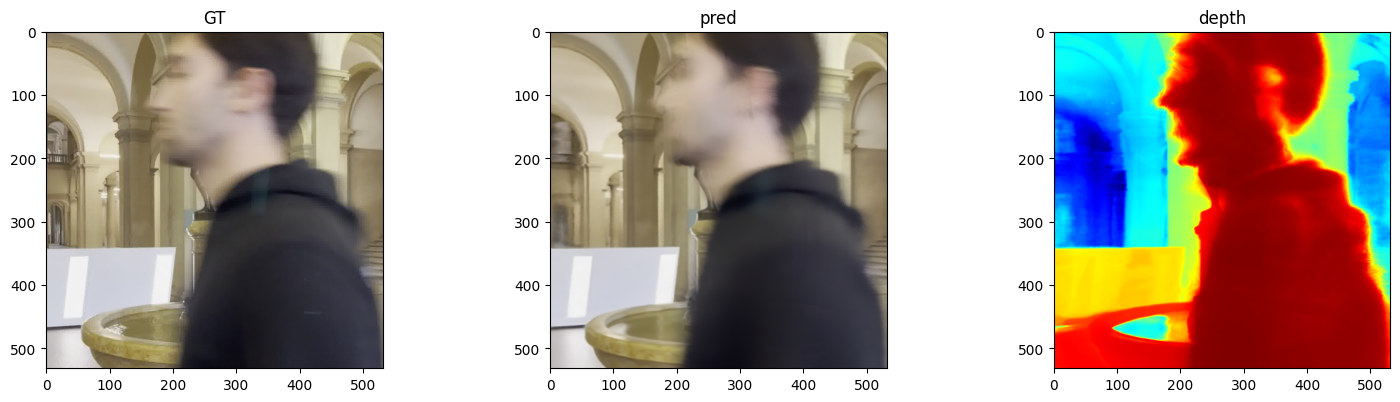

PSNR between GT and pred: 32.21139907836914 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


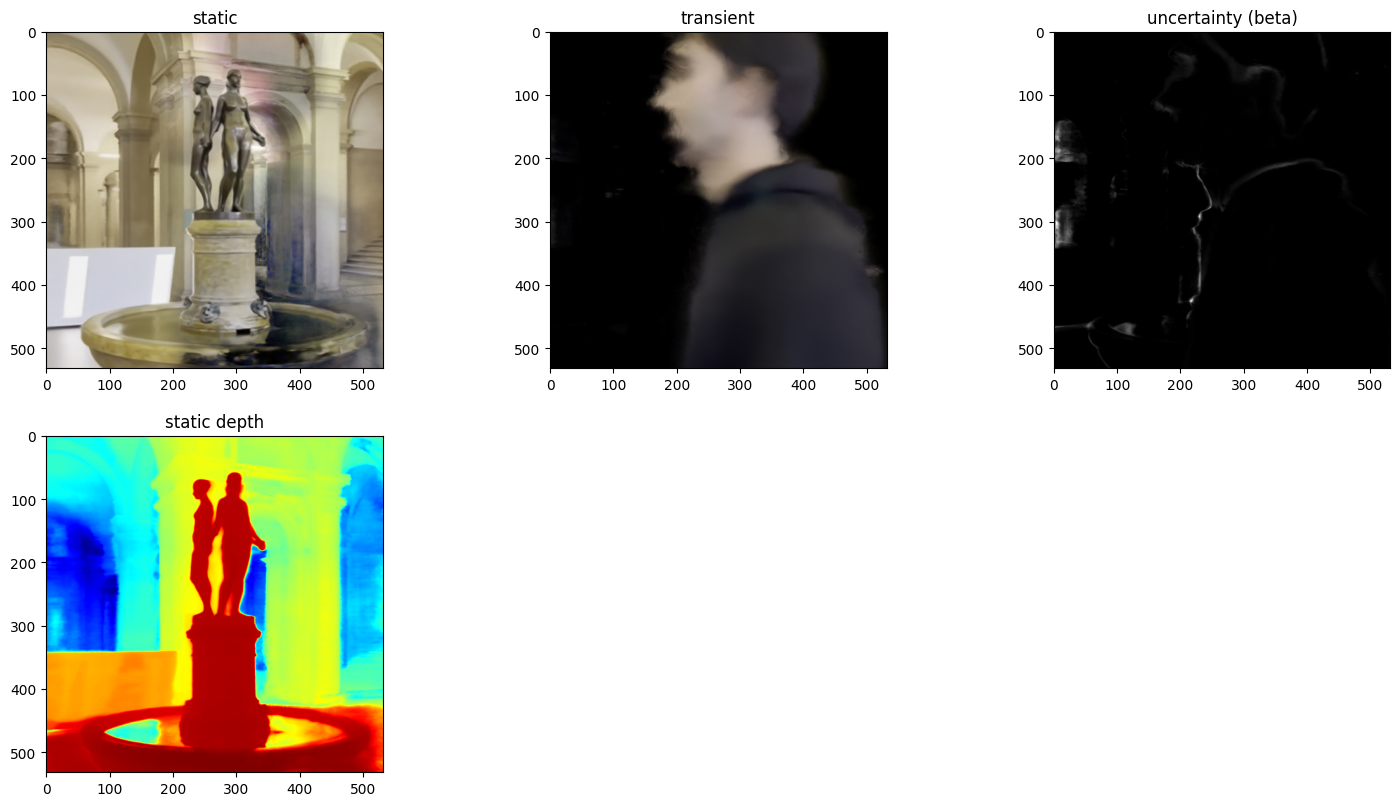

In [7]:
img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['_rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(231)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(232)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(233)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray')
    plt.subplot(234)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.show()

# Test on another highly occluded data

In [64]:
sample = dataset[58]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


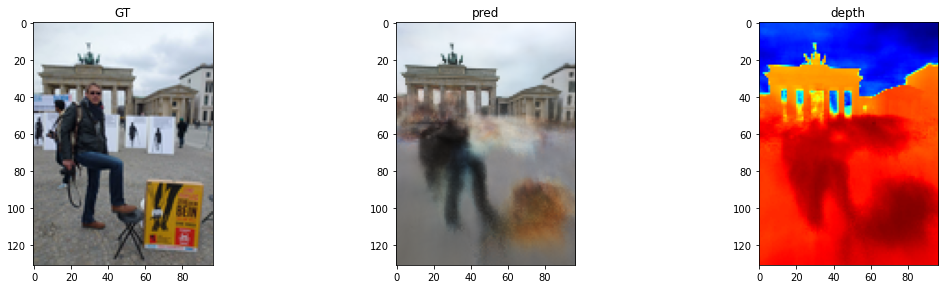

PSNR between GT and pred: 18.96710968017578 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


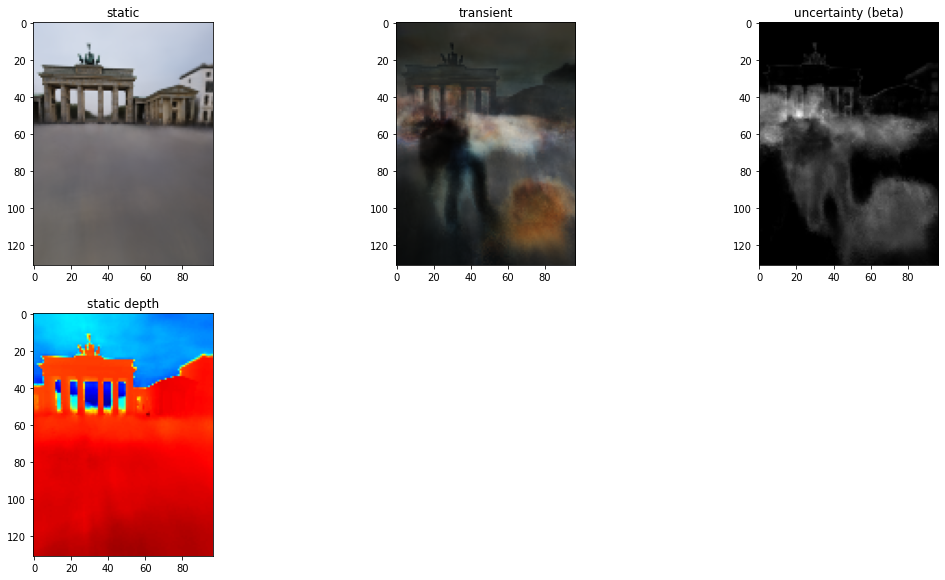

In [67]:
img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['_rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(231)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(232)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(233)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray')
    plt.subplot(234)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.show()

# Interpolate embedding for appearance change (Fig 8 in the paper)
### left image: train number 53; right image: train number 111
### The pose is fixed to that of the right image, and the appearance embedding is interpolated

In [84]:
left_sample = dataset[53]
right_sample = dataset[111]

right_rays = right_sample['rays'].cuda()
right_ts = right_sample['ts'].cuda()
left_a_embedded = embedding_a(left_sample['ts'][0].cuda())
right_a_embedded = embedding_a(right_sample['ts'].cuda())

results_list = [left_sample]

for i in range(5):
    kwargs = {'a_embedded': right_a_embedded*i/4+left_a_embedded*(1-i/4)}
    results_list += [f(right_rays, right_ts, **kwargs)]

results_list += [right_sample]

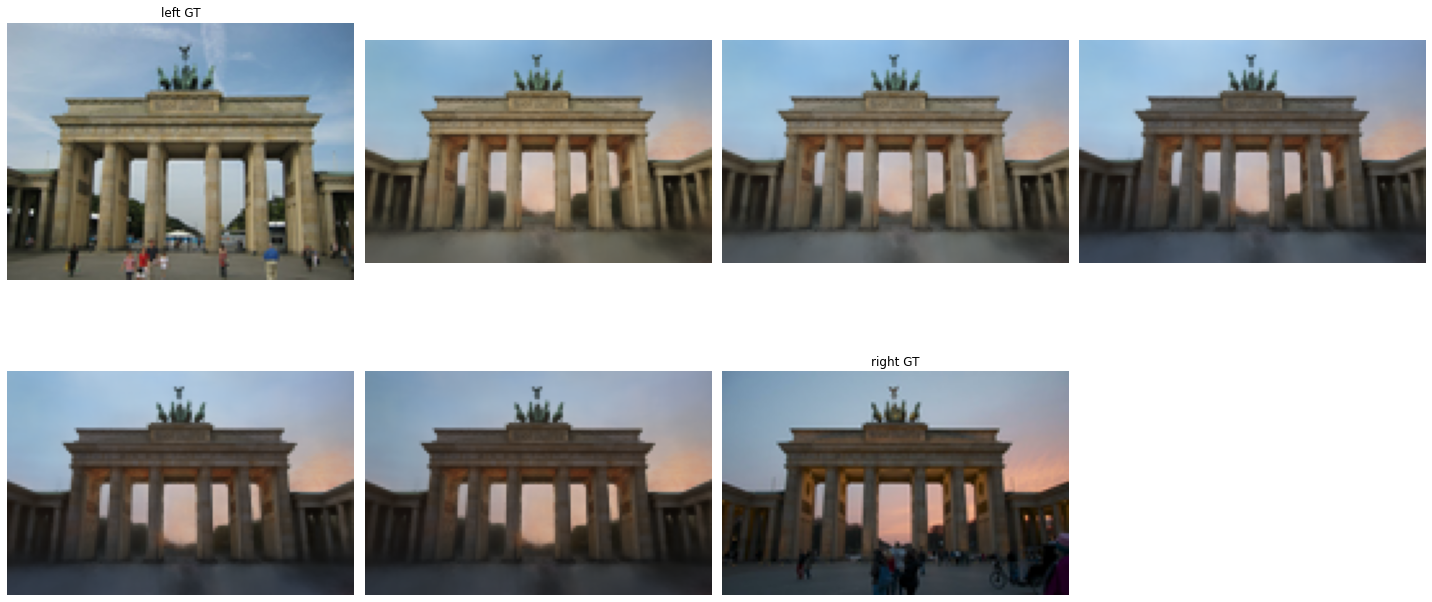

In [85]:
plt.subplots(figsize=(20, 10))
for i, results in enumerate(results_list):
    if i == 0:
        img_wh = tuple(results['img_wh'].numpy())
        left_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(241)
        plt.axis('off')
        plt.title('left GT')
        plt.imshow(left_GT)
    elif i == 6:
        img_wh = tuple(results['img_wh'].numpy())
        right_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(247)
        plt.axis('off')
        plt.title('right GT')
        plt.imshow(right_GT)
    else:
        img_wh = tuple(right_sample['img_wh'].numpy())
        img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img_pred)
plt.tight_layout()
plt.show()